In [7]:
#importing the required frameworks
import tensorflow as tf
print(tf.__version__)
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import imutils
import time
import cv2
import os

2.4.0


In [8]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths 


In [9]:
#initial learning rate, no.of epocs and batch size for training

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [10]:
#path for the files

DIRECTORY ='/gdrive/My Drive/Colab Notebooks/dataset'
CATEGORIES = ["with_mask","without_mask"]

In [11]:
data =[]
lables = []

In [12]:
#mounting the google drive

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [13]:
#loading the images and correspoding lables from the directory

print("[INFO] loading images...")
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    image = load_img(img_path, target_size = (224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    lables.append(category)
    

[INFO] loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [14]:
#converting the lables from text to binary format

lb = LabelBinarizer()
lables = lb.fit_transform(lables)
lables = to_categorical(lables)

In [15]:
#converting the data to numpy arrays so that its compatable for training
data = np.array(data, dtype = "float32")
lables = np.array(lables)

In [16]:
#test train split of data
(train_x,test_x,train_y,test_y) = train_test_split(data, lables, 
                                                   test_size = 0.20, 
                                                   stratify = lables, 
                                                   random_state = 25)

In [17]:
# data augmentation

aug = ImageDataGenerator(rotation_range = 40,
                         zoom_range = 0.2,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = 'nearest')

In [18]:
#loading the MobileNetV2 model
baseModel = MobileNetV2(weights = "imagenet", include_top = False,
                        input_tensor = Input(shape = (224,224,3)))

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
#fixing the MobileNetV2 model layers as not trainable
for layer in baseModel.layers:
  layer.trainable = False

In [20]:
#adding of additional layers required - Skeleton of the model

headModel = baseModel.output
headMOdel = tf.keras.layers.AveragePooling2D(pool_size = (5,5))(headModel)
headModel = tf.keras.layers.Flatten(name = "flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation = "relu")(headModel)
headModel = tf.keras.layers.Dropout(0.4)(headModel)
headModel = tf.keras.layers.Dense(2, activation = "softmax")(headModel)

In [21]:
#compiling of the model and choosing an optimizer to accelarate the learning

model = Model(inputs = baseModel.input, outputs = headModel)

print("[INFO] compiling model...")
opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = "binary_crossentropy", optimizer = opt,
              metrics = ["accuracy"])

[INFO] compiling model...


In [22]:
#training the model

print("[INFO] training head....")

H = model.fit(aug.flow(train_x, train_y, batch_size = BS),
              steps_per_epoch = len(train_x)//BS,
              validation_data = (test_x, test_y),
              validation_steps = len(test_x)//BS,
              epochs = EPOCHS)

[INFO] training head....
Epoch 1/20
96/96 [==============================] - 164s 2s/step - loss: 0.2828 - accuracy: 0.9130 - val_loss: 0.0563 - val_accuracy: 0.9753
Epoch 2/20
96/96 [==============================] - 161s 2s/step - loss: 0.0757 - accuracy: 0.9785 - val_loss: 0.0385 - val_accuracy: 0.9831
Epoch 3/20
96/96 [==============================] - 160s 2s/step - loss: 0.0470 - accuracy: 0.9859 - val_loss: 0.0460 - val_accuracy: 0.9831
Epoch 4/20
96/96 [==============================] - 160s 2s/step - loss: 0.0442 - accuracy: 0.9846 - val_loss: 0.0396 - val_accuracy: 0.9857
Epoch 5/20
96/96 [==============================] - 160s 2s/step - loss: 0.0527 - accuracy: 0.9795 - val_loss: 0.0377 - val_accuracy: 0.9896
Epoch 6/20
96/96 [==============================] - 160s 2s/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.0448 - val_accuracy: 0.9844
Epoch 7/20
96/96 [==============================] - 161s 2s/step - loss: 0.0303 - accuracy: 0.9875 - val_loss: 0.0384 - val_accur

In [23]:
#summary of the trained model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [24]:
#prediciton on the test data set

print("[INFO] evaluating network ...")
preds = model.predict(test_x, batch_size = BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
preds = np.argmax(preds, axis = 1)

[INFO] evaluating network ...


In [25]:
# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), preds,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/gdrive/My Drive/Colab Notebooks/dataset/mask_detector.model", save_format="h5")

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       385
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769

[INFO] saving mask detector model...


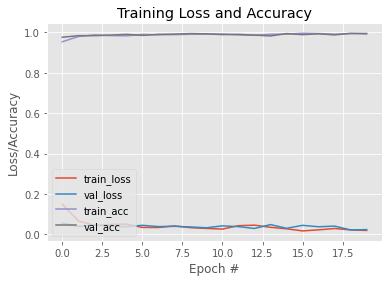

In [26]:
#plots indiacting the accuracies and loss on both training and validation set

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")